In [1]:
#Importamos pandas
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
import re

# Análisis Exploratorio de Datos

Cargamos el archivo con los datos

In [2]:
# Carga tus datos
df = pd.read_csv('movies_ETL.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

Observamos las primeras filas de los datos

In [3]:
df.head()

,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,...,collection_poster_path,collection_backdrop_path,production_companies_ids,production_companies_names,production_countries_names,production_countries_iso,spoken_languages_names,spoken_languages_iso,director,principal_actor
0,30000000.0,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,0,...,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg,[3],['Pixar Animation Studios'],['United States of America'],['US'],['English'],['en'],['John Lasseter'],NaN
1,65000000.0,8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,...,NaN,NaN,"[559, 2550, 10201]","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"['English', 'Français']","['en', 'fr']",['Joe Johnston'],Robin Williams
2,0.0,15602,en,A family wedding reignites the ancient feud be...,11.712900,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,...,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg,"[6194, 19464]","['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],['English'],['en'],['Howard Deutch'],NaN
3,16000000.0,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,Friends are the people who let you be yourself...,...,NaN,NaN,[306],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],['English'],['en'],['Forest Whitaker'],Whitney Houston
4,0.0,11862,en,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,...,/nts4iOmNnq7GNicycMJ9pSAn204.jpg,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg,"[5842, 9195]","['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],['US'],['English'],['en'],['Charles Shyer'],Steve Martin


## Analisis de las variables

## Analisis General

In [4]:
x=df.info()
print(x) # Vemos un resumen de todas las variables disponibles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45452 entries, 0 to 45451
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   budget                      45452 non-null  float64
 1   id_movie                    45452 non-null  int64  
 2   original_language           45452 non-null  object 
 3   overview                    45452 non-null  object 
 4   popularity                  45452 non-null  float64
 5   release_date                45452 non-null  object 
 6   revenue                     45452 non-null  float64
 7   runtime                     45452 non-null  float64
 8   status                      45452 non-null  object 
 9   tagline                     45452 non-null  object 
 10  title                       45452 non-null  object 
 11  vote_average                45452 non-null  float64
 12  vote_count                  45452 non-null  float64
 13  release_year                454

Vamos a iniciar descartando variables de nulo interes para el modelo como lo son: "collection_poster_path", "collection_backdrop_path", "spoken_languages_iso" y "status"

In [5]:
df.drop(columns= ['collection_poster_path', "collection_backdrop_path", "spoken_languages_iso", "status"], axis= 1, inplace= True)

### Variables numericas

In [6]:
# Reemplazar los valores 'inf' por 0 en la columna 'return'
df['return'] = df['return'].replace([float('inf')], 0)

df.describe() # Vamos a ver caracteristicas como la cantidad, la media y la dispersion de las variables numericas

,budget,id_movie,popularity,revenue,runtime,vote_average,vote_count,release_year,return,id_collection
count,4.545200e+04,45452.000000,45452.000000,4.545200e+04,45452.000000,45452.000000,45452.000000,45452.000000,4.545200e+04,4497.000000
mean,4.231201e+06,107991.064926,2.926828,1.121905e+07,93.670092,5.623962,109.987283,1991.882579,6.589397e+02,183889.401379
std,1.742923e+07,112118.576134,6.006405,6.433916e+07,38.847259,1.915585,491.347202,24.057750,7.463082e+04,141616.252430
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000,0.000000e+00,10.000000
25%,0.000000e+00,26367.750000,0.389040,0.000000e+00,85.000000,5.000000,3.000000,1978.000000,0.000000e+00,85960.000000
50%,0.000000e+00,59872.000000,1.131324,0.000000e+00,95.000000,6.000000,10.000000,2001.000000,0.000000e+00,141448.000000
75%,0.000000e+00,156330.500000,3.694242,0.000000e+00,107.000000,6.800000,34.000000,2010.000000,0.000000e+00,294172.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000,1.239638e+07,480160.000000


- budget: Esta es la cantidad de dinero presupuestada para la película. El presupuesto promedio es de alrededor de 4.2 millones de dólares, aunque la desviación estándar es alta, lo que sugiere que mucha variacion entre los presupuestos de las peliculas en principio.

- id_movie: Este es un identificador único para cada película. No tiene sentido estadístico real, pero es útil para la indexación y el cruce con otros datos.

- popularity: El promedio de popularidad de las películas es de alrededor de 2.93, con una desviación estándar de 6, lo que sugiere una amplia gama de valores de popularidad.

- release_date y release_year: Fecha y año de lanzamiento de la película. Las películas en el conjunto de datos se lanzaron entre 1874 y 2020, con una tendencia hacia las películas más recientes.

- revenue: La recaudación promedio de las películas es de alrededor de 11.2 millones de dólares, pero con una gran desviación estándar que indica una amplia gama de valores de ingresos.

- runtime: El tiempo de duración promedio de las películas es de alrededor de 93.67 minutos, con una desviación estándar de 38.85, lo que indica una variación moderada en los tiempos de duración de las películas.

- vote_average: El puntaje promedio de la película es de alrededor de 5.62 con una desviación estándar de 1.92, lo que sugiere una variación moderada en los puntajes de las películas.

- vote_count: El conteo de votos varía ampliamente, con una media de alrededor de 109.98 y una desviación estándar de 491.35.

- return: representa la relación entre los ingresos y el presupuesto de una película. Un retorno más alto indica que una película generó más ingresos en relación con su presupuesto. Sin embargo, la falta de datos completos puede hacer que algunos valores de retorno sean engañosos. Por ejemplo, una película con un presupuesto muy pequeño y ganancias moderadas puede tener un retorno muy alto, mientras que una película con un gran presupuesto y grandes ganancias puede tener un retorno más bajo. Aun así, el retorno puede ser una variable útil para entender qué tan exitosa fue una película financieramente.

### Correlacion entre variables

In [7]:
correlation_matrix = df.corr()

C:\Users\Matias\AppData\Local\Temp\ipykernel_10744\4214245630.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Elaboramos un heat map para poder vizualizar las correlaciones de mejor forma

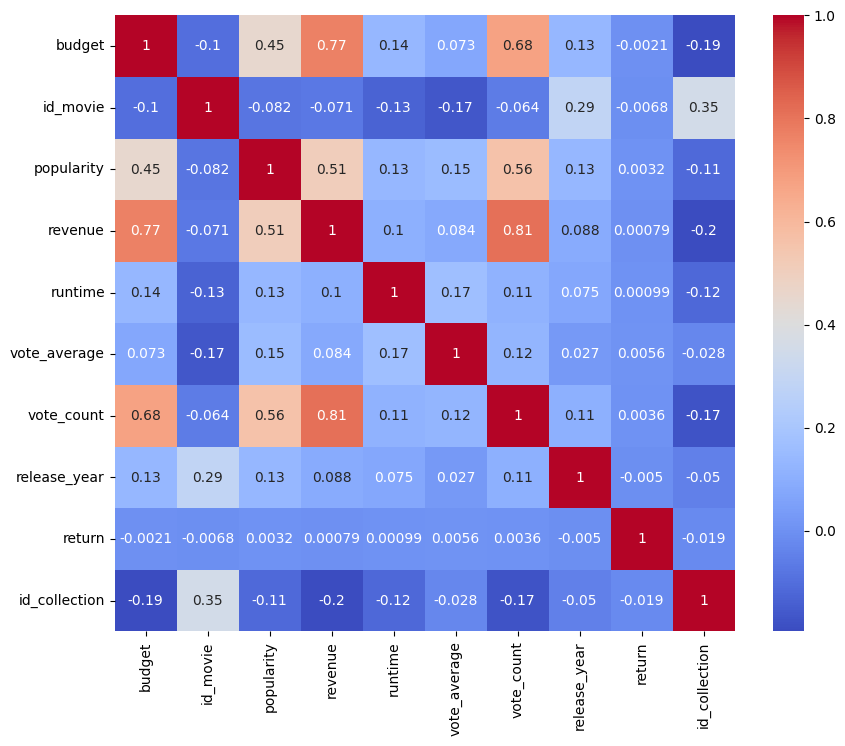

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Analisis del Heat Map

Del Heat Map se desprenden lo siguiente:

- budget y revenue: Con una correlación de 0.768665, estas dos características parecen tener una fuerte correlación positiva. Esto tiene sentido porque a menudo cuanto más grande es el presupuesto de una película, más alto es el ingreso esperado.

- popularity y vote_count: Con una correlación de 0.559847, estas dos características también tienen una fuerte correlación positiva. Esto también es intuitivo porque las películas más populares tienden a tener más votos.

- vote_count y revenue: Con una correlación de 0.811994, estas dos características también tienen una fuerte correlación positiva. Esto sugiere que las películas con más votos tienden a generar más ingresos, lo que tiene sentido ya que las películas más populares a menudo son las que generan más ingresos.

- return parece no estar fuertemente correlacionado con ninguna de las otras características, lo que podría indicar que la rentabilidad de una película (es decir, su ingreso dividido por el presupuesto) no se ve fuertemente afectada por ninguna de las otras características en el conjunto de datos.

## Analisis de "budget"

Vamos a analizar por separado estas variables, iniciamos por budget, que representa el presupuesta de la pelicula. Empecemos viendo la distribucion de esta variable.

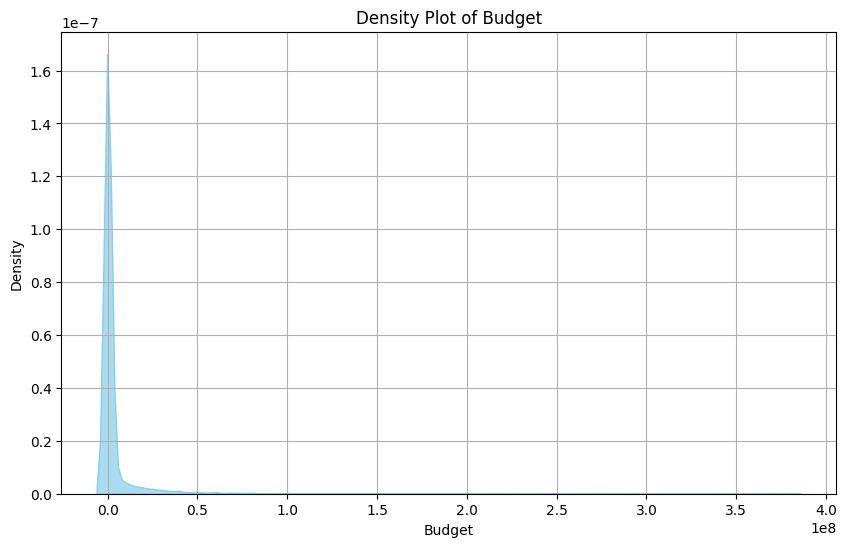

0.0            36544
5000000.0        286
10000000.0       261
20000000.0       243
2000000.0        242
               ...  
270000000.0        1
923.0              1
72500000.0         1
2160000.0          1
1254040.0          1
Name: budget, Length: 1223, dtype: int64


In [9]:
# Utilizar la función value_counts para obtener la distribución de frecuencia de la variable 'budget'
distribucion_frecuencia = df['budget'].value_counts()

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.kdeplot(data=df, x='budget', fill=True, color='skyblue', alpha=0.7)  # Gráfico de densidad
plt.xlabel('Budget')  # Etiqueta del eje x
plt.ylabel('Density')  # Etiqueta del eje y
plt.title('Density Plot of Budget')  # Título del gráfico
plt.grid(True)  # Agregar líneas de cuadrícula
plt.show()  # Mostrar el gráfico

# Mostrar el resultado
print(distribucion_frecuencia)

In [10]:
# Calcular el total de películas en el DataFrame
total_peliculas = len(df)

# Filtrar las películas con un presupuesto de 0
peliculas_sin_presupuesto = df[df['budget'] == 0]

# Calcular el total de películas sin presupuesto
total_peliculas_sin_presupuesto = len(peliculas_sin_presupuesto)

# Calcular el porcentaje
porcentaje_peliculas_sin_presupuesto = (total_peliculas_sin_presupuesto / total_peliculas) * 100

# Mostrar el resultado
print(f"El {porcentaje_peliculas_sin_presupuesto:.2f}% de las películas del DataFrame no tienen presupuesto cargado.")

El 80.40% de las películas del DataFrame no tienen presupuesto cargado.


Vemos que de el total de peliculas el 80,4% no tiene ningun presupuesto cargado en la base de datos, este numero es muy grande y hace poco util calcular la media o la desviacion estandar con los datos como estan ya que los resultados no seran representativos.

## Analisis de "revenue"

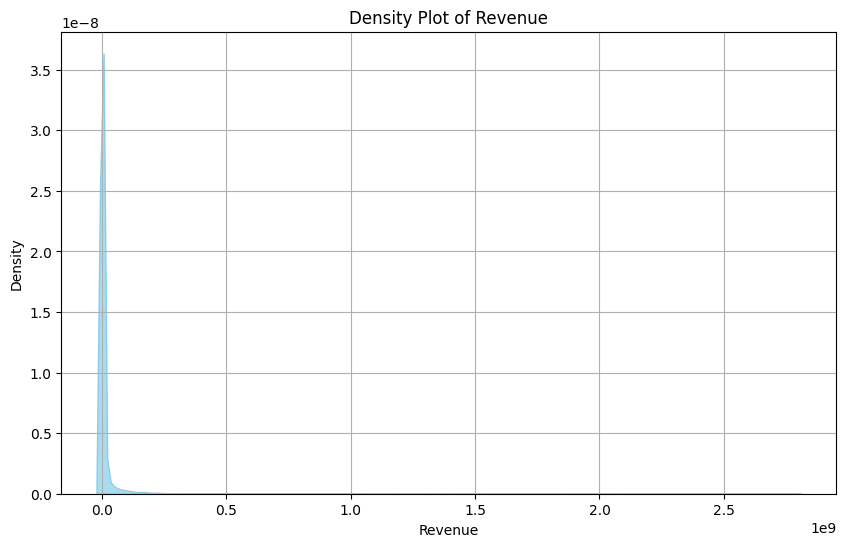

0.0           38025
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: revenue, Length: 6863, dtype: int64


In [11]:
# Utilizar la función value_counts para obtener la distribución de frecuencia de la variable 'budget'
distribucion_frecuencia = df['revenue'].value_counts()

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.kdeplot(data=df, x='revenue', fill=True, color='skyblue', alpha=0.7)  # Gráfico de densidad
plt.xlabel('Revenue')  # Etiqueta del eje x
plt.ylabel('Density')  # Etiqueta del eje y
plt.title('Density Plot of Revenue')  # Título del gráfico
plt.grid(True)  # Agregar líneas de cuadrícula
plt.show()  # Mostrar el gráfico

# Mostrar el resultado
print(distribucion_frecuencia)

In [12]:
# Calcular el total de películas en el DataFrame
total_peliculas = len(df)

# Filtrar las películas con un presupuesto de 0
peliculas_sin_presupuesto = df[df['revenue'] == 0]

# Calcular el total de películas sin presupuesto
total_peliculas_sin_presupuesto = len(peliculas_sin_presupuesto)

# Calcular el porcentaje
porcentaje_peliculas_sin_presupuesto = (total_peliculas_sin_presupuesto / total_peliculas) * 100

# Mostrar el resultado
print(f"El {porcentaje_peliculas_sin_presupuesto:.2f}% de las películas del DataFrame no tienen cargado sus ingresos.")

El 83.66% de las películas del DataFrame no tienen cargado sus ingresos.


Al igual que con budget, revenue no tiene datos en el 83,66% del dataframe, lo que hace que no sea una buena variable decisora, intentar completar los datos con la mediana no seria util en este caso por la gran cantidad de datos faltantes que existen, la variable no va a aportar gran valor a nuestro modelo

## Variable "return"

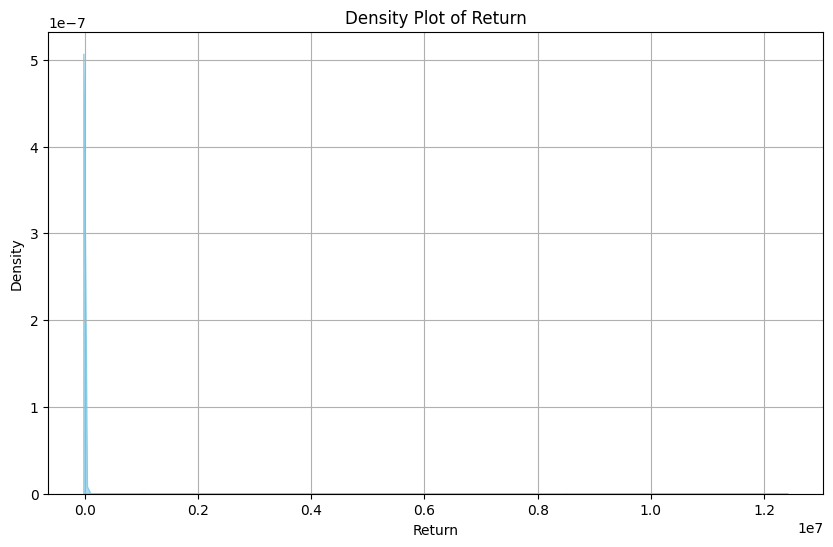

0.000000     40059
1.000000        20
2.000000        12
4.000000        11
5.000000         8
             ...  
17.000000        1
0.277950         1
5.411653         1
4.777778         1
0.282600         1
Name: return, Length: 5232, dtype: int64


In [13]:
# Utilizar la función value_counts para obtener la distribución de frecuencia de la variable 'budget'
distribucion_frecuencia = df['return'].value_counts()

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
sns.kdeplot(data=df, x='return', fill=True, color='skyblue', alpha=0.7)  # Gráfico de densidad
plt.xlabel('Return')  # Etiqueta del eje x
plt.ylabel('Density')  # Etiqueta del eje y
plt.title('Density Plot of Return')  # Título del gráfico
plt.grid(True)  # Agregar líneas de cuadrícula
plt.show()  # Mostrar el gráfico

# Mostrar el resultado
print(distribucion_frecuencia)

In [14]:
# Calcular el total de películas en el DataFrame
total_peliculas = len(df)

# Filtrar las películas con un presupuesto de 0
peliculas_sin_presupuesto = df[df['return'] == 0]

# Calcular el total de películas sin presupuesto
total_peliculas_sin_presupuesto = len(peliculas_sin_presupuesto)

# Calcular el porcentaje
porcentaje_peliculas_sin_presupuesto = (total_peliculas_sin_presupuesto / total_peliculas) * 100

# Mostrar el resultado
print(f"El {porcentaje_peliculas_sin_presupuesto:.2f}% de las películas del DataFrame no tienen cargado informacion de su retorno.")

El 88.13% de las películas del DataFrame no tienen cargado informacion de su retorno.


Resultado logico ya que returno es budget/revenue, esta variable aportara muy poco valor a nuestro modelo.

## Variable popularity

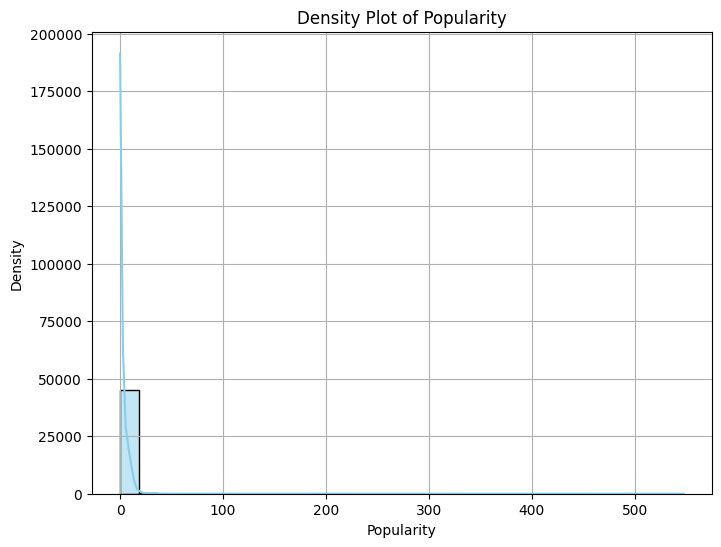

0.000001    56
0.000308    42
0.000000    40
0.000220    39
0.000578    38
            ..
0.645652     1
0.556292     1
0.914133     1
0.858836     1
0.163015     1
Name: popularity, Length: 43731, dtype: int64


In [15]:
# Utilizar la función value_counts para obtener la distribución de frecuencia de la variable 'budget'
distribucion_frecuencia = df['popularity'].value_counts()

# Gráfico de densidad para la distribución de "popularity"
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='popularity', bins=30, kde=True, color='skyblue', edgecolor='k')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.title('Density Plot of Popularity')
plt.grid(True)
plt.show()

# Mostrar el resultado
print(distribucion_frecuencia)

Por el histograma obtenido parece que la variable popularity tiene outliers de pelicular con un valor de popularidad muy grandes, vamos a verlo en un boxplot

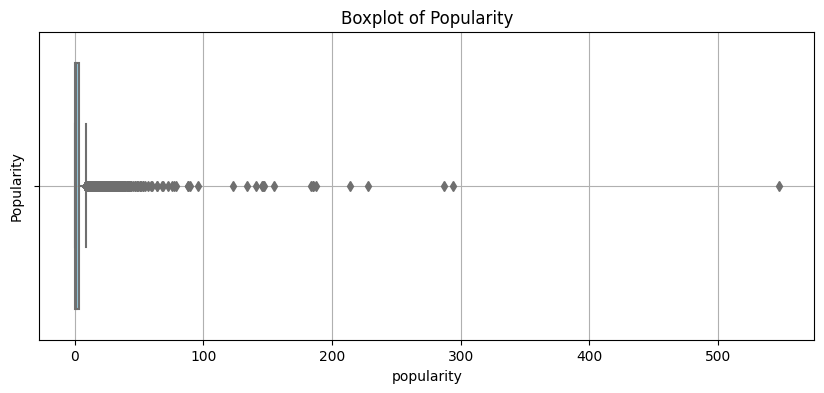

In [16]:
# Crear el boxplot para la distribución de "popularity"
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='popularity', color='skyblue')
plt.ylabel('Popularity')
plt.title('Boxplot of Popularity')
plt.grid(True)
plt.show()

Se pueden apreciar por la forma achatada del grafico de caja en la izquierda que la variable tiene muchos outliers que pueden estar afectando el analisis al momento de usar esta variable.

En primer lugar para saber como tratar con estos datos vamos a intentar identificarlos, para eso vamos a utilizar la tecnica estadística de los límites de Tukey para detectar outliers. Este método considera outliers aquellos valores que están por encima del tercer cuartil más 1.5 veces el rango intercuartil (IQR) o por debajo del primer cuartil menos 1.5 veces el IQR son outliers.

In [17]:
# Método de Tukey para identificar outliers
Q1 = df['popularity'].quantile(0.25)
Q3 = df['popularity'].quantile(0.75)
IQR = Q3 - Q1
umbral_superior = Q3 + 1.5 * IQR
umbral_inferior = Q1 - 1.5 * IQR

# Identificar los outliers
outliers = df[(df['popularity'] < umbral_inferior) | (df['popularity'] > umbral_superior)]

In [18]:
outliers.sort_values(by= 'popularity', ascending= False)

,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,...,genero_names,id_collection,name_collection,production_companies_ids,production_companies_names,production_countries_names,production_countries_iso,spoken_languages_names,director,principal_actor
30731,74000000.0,211672,en,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,2015-06-17,1.156731e+09,91.0,"Before Gru, they had a history of bad bosses",Minions,...,"['Family', 'Animation', 'Adventure', 'Comedy']",86066.0,Despicable Me Collection,"[33, 6704]","['Universal Pictures', 'Illumination Entertain...",['United States of America'],['US'],['English'],"['Kyle Balda', 'Pierre Coffin']",NaN
33383,149000000.0,297762,en,An Amazon princess comes to the world of Man t...,294.337037,2017-05-30,8.205804e+08,141.0,Power. Grace. Wisdom. Wonder.,Wonder Woman,...,"['Action', 'Adventure', 'Fantasy']",468552.0,Wonder Woman Collection,"[444, 507, 6194, 9993, 9995, 81620, 83838]","['Dune Entertainment', 'Atlas Entertainment', ...",['United States of America'],['US'],"['Deutsch', 'English']",['Patty Jenkins'],NaN
42224,160000000.0,321612,en,A live-action adaptation of Disney's version o...,287.253654,2017-03-16,1.262886e+09,129.0,Be our guest.,Beauty and the Beast,...,"['Family', 'Fantasy', 'Romance']",NaN,NaN,"[2, 10227]","['Walt Disney Pictures', 'Mandeville Films']","['United Kingdom', 'United States of America']","['GB', 'US']",['English'],['Bill Condon'],NaN
43640,34000000.0,339403,en,After being coerced into working for a crime b...,228.032744,2017-06-28,2.245113e+08,113.0,All you need is one killer track.,Baby Driver,...,"['Action', 'Crime']",NaN,NaN,"[443, 559, 2531, 10163, 31922]","['Big Talk Productions', 'TriStar Pictures', '...","['United Kingdom', 'United States of America']","['GB', 'US']",['English'],['Edgar Wright'],NaN
24473,165000000.0,177572,en,The special bond that develops between plus-si...,213.849907,2014-10-24,6.521054e+08,102.0,From the creators of Wreck-it Ralph and Frozen,Big Hero 6,...,"['Adventure', 'Family', 'Animation', 'Action',...",NaN,NaN,"[2, 6125]","['Walt Disney Pictures', 'Walt Disney Animatio...",['United States of America'],['US'],['English'],"['Chris Williams', 'Don Hall']",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,53000000.0,8963,en,"On a US nuclear missile sub, a young first off...",8.657365,1995-05-12,1.573872e+08,116.0,Danger runs deep.,Crimson Tide,...,"['Action', 'Thriller', 'Drama']",NaN,NaN,"[915, 10288]","['Hollywood Pictures', 'Don Simpson/Jerry Bruc...",['United States of America'],['US'],['English'],['Tony Scott'],NaN
7719,424000.0,16391,en,"After opening a convent in the Himalayas, five...",8.657125,1947-01-01,0.000000e+00,100.0,0,Black Narcissus,...,['Drama'],NaN,NaN,[11382],['The Archers'],['United Kingdom'],['GB'],"['English', 'हिन्दी']","['Emeric Pressburger', 'Michael Powell']",Deborah Kerr
12438,0.0,15365,en,The story centers on a small-town sheriff who ...,8.655423,2008-02-22,0.000000e+00,97.0,Protecting America's assets.,Witless Protection,...,"['Action', 'Adventure', 'Comedy', 'Crime']",NaN,NaN,[5122],['Parallel Films'],['United States of America'],['US'],['English'],['Charles Robert Carner'],Larry the Cable Guy
1035,0.0,11238,en,Legendary secrets are revealed as Aladdin and ...,8.654244,1996-05-20,0.000000e+00,81.0,The Spectacular Adventure Continues!,Aladdin and the King of Thieves,...,"['Adventure', 'Animation', 'Family']",86027.0,Aladdin Collection,[3475],['Walt Disney Television Animation'],['United States of America'],['US'],['English'],['Tad Stones'],NaN


Vemos que hay 4211 registros que se categorizan como outliers, vamosa  comparar estos valores atipicos con los que no son atipicos mediante la feature "vote_count" que habiamos viste que estaban correlacionadas positivamente.

In [19]:
# Máscara booleana para los registros que no son outliers
mascara_no_outliers = ~df.index.isin(outliers.index)

# DataFrame sin outliers
df_no_outliers = df[mascara_no_outliers]

print(df_no_outliers['vote_average'].describe())

print(outliers['vote_average'].describe())

count    41241.000000
mean         5.547094
std          1.974797
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64
count    4211.000000
mean        6.376775
std         0.888294
min         0.000000
25%         5.800000
50%         6.400000
75%         7.000000
max         9.100000
Name: vote_average, dtype: float64


Vamos a realizar una prueba de hipotesis para determinar si el vote_average estadisticamente es igual para el conjunto sin outliers y el conjunto de outliers.

In [20]:
from scipy import stats

# Realiza la prueba t de Student para muestras independientes.
t_statistic, p_value = stats.ttest_ind(df_no_outliers['vote_average'], outliers['vote_average'])

# Imprime los resultados.
print("Estadística t:", t_statistic)
print("Valor p:", p_value)

# Realiza la decisión basada en el valor p y un nivel de significancia (α) de 0.05.
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Las poblaciones tienen medias diferentes.")
else:
    print("No podemos rechazar la hipótesis nula. Las poblaciones podrían tener la misma media.")

Estadística t: -26.985940751048332
Valor p: 3.905322461986716e-159
Rechazamos la hipótesis nula. Las poblaciones tienen medias diferentes.


Estadisticamente, con un nivel de confianza del 95%, los outliers si cuentan con una cantidad de votos mayor a los que no son outliers, ya que su media es mayor, lo que nos podria indicar que estos valores son correctos, no son valores incorrectos sino que realmente son peliculas muy populares.

Para cerrar el analisis de esta variable a continuacion vamos ver cuales son el top 10 de peliculas con mayor popularidad

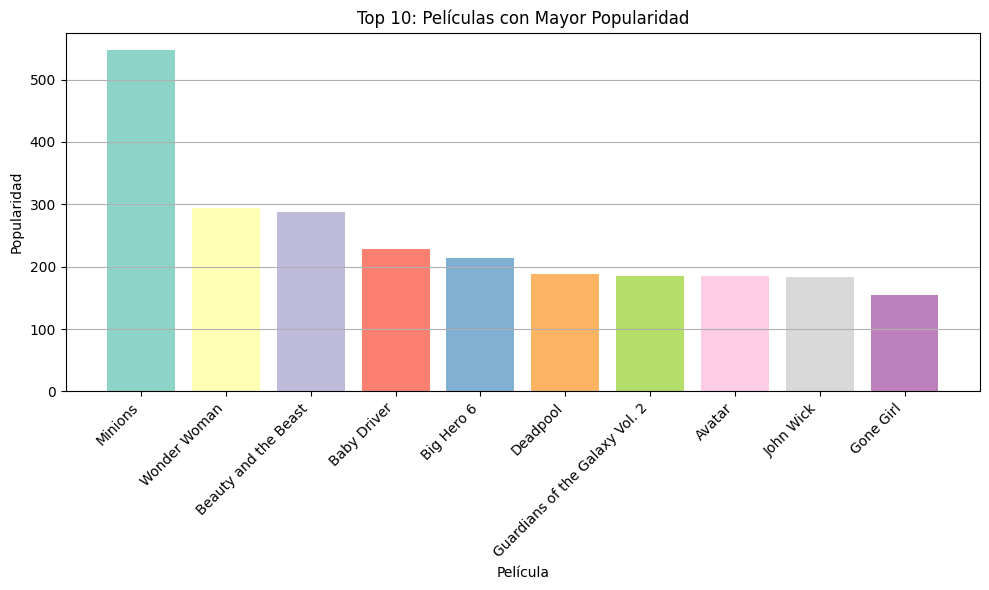

In [21]:
# Ordenar el DataFrame por popularidad en orden descendente
df_top_popularity = df.sort_values(by='popularity', ascending=False)

# Tomar las 10 primeras filas del DataFrame ordenado (Top 10)
df_top_10 = df_top_popularity.head(10)

# Ordenar el DataFrame por popularidad en orden descendente
df_top_popularity = df.sort_values(by='popularity', ascending=False)

# Tomar las 10 primeras filas del DataFrame ordenado (Top 10)
df_top_10 = df_top_popularity.head(10)

# Crear el gráfico de barras para el Top 10 de películas con mayor popularidad
plt.figure(figsize=(10, 6))
colors = sns.color_palette('Set3', n_colors=len(df_top_10))  # Paleta de colores
plt.bar(df_top_10['title'], df_top_10['popularity'], color=colors)
plt.xlabel('Película')
plt.ylabel('Popularidad')
plt.title('Top 10: Películas con Mayor Popularidad')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad
plt.grid(axis='y')  # Agregar rejillas en el eje y para guiar la lectura
plt.tight_layout()  # Ajustar los espacios para una mejor presentación
plt.show()

Con base en estos hallazgos, podemos concluir que la variable "popularity" es un indicador relevante para medir el interés y la relevancia de una película en la plataforma de TMDB. Las películas con una popularidad excepcionalmente alta pueden ser consideradas como aquellas que han capturado la atención y el interés del público, lo que podría ser un factor importante para tener en cuenta en el análisis y la toma de decisiones relacionadas con el contenido y la promoción.

### Variables categoricas

In [22]:
# Convierte los strings a listas
df['genero_names'] = df['genero_names'].apply(ast.literal_eval)

# "Aplana" las listas, cuenta los valores, y selecciona los 10 primeros
top_10_generos = df['genero_names'].explode().value_counts()[:10]

print(top_10_generos)

Drama              20302
Comedy             13195
Thriller            7635
Romance             6744
Action              6603
Horror              4676
Crime               4312
Documentary         3926
Adventure           3506
Science Fiction     3054
Name: genero_names, dtype: int64


In [23]:
top_10_collections = df['name_collection'].explode().value_counts()[:10]
print(top_10_collections)

The Bowery Boys                           29
Totò Collection                           27
James Bond Collection                     26
Zatôichi: The Blind Swordsman             26
Pokémon Collection                        26
The Carry On Collection                   25
Charlie Chan (Sidney Toler) Collection    21
Godzilla (Showa) Collection               16
Uuno Turhapuro                            15
Dragon Ball Z (Movie) Collection          15
Name: name_collection, dtype: int64


In [24]:
df['production_companies_names'] = df['production_companies_names'].apply(ast.literal_eval)
top_10_productoras = df['production_companies_names'].explode().value_counts()[:10]
print(top_10_productoras)

Warner Bros.                              1250
Metro-Goldwyn-Mayer (MGM)                 1080
Paramount Pictures                        1007
Twentieth Century Fox Film Corporation     836
Universal Pictures                         830
Columbia Pictures Corporation              448
Canal+                                     442
Columbia Pictures                          431
RKO Radio Pictures                         290
United Artists                             279
Name: production_companies_names, dtype: int64


In [25]:
df['production_countries_names'] = df['production_countries_names'].apply(ast.literal_eval)
top_10_paises=df['production_countries_names'].explode().value_counts()[:10]
print(top_10_paises)

United States of America    21176
United Kingdom               4100
France                       3956
Germany                      2266
Italy                        2174
Canada                       1766
Japan                        1654
Spain                         964
Russia                        911
India                         829
Name: production_countries_names, dtype: int64


In [26]:
top_10_or_languaje = df['original_language'].explode().value_counts()[:10]
print(top_10_or_languaje)

en    32249
fr     2442
it     1528
ja     1355
de     1081
es      992
ru      822
hi      508
ko      444
zh      408
Name: original_language, dtype: int64


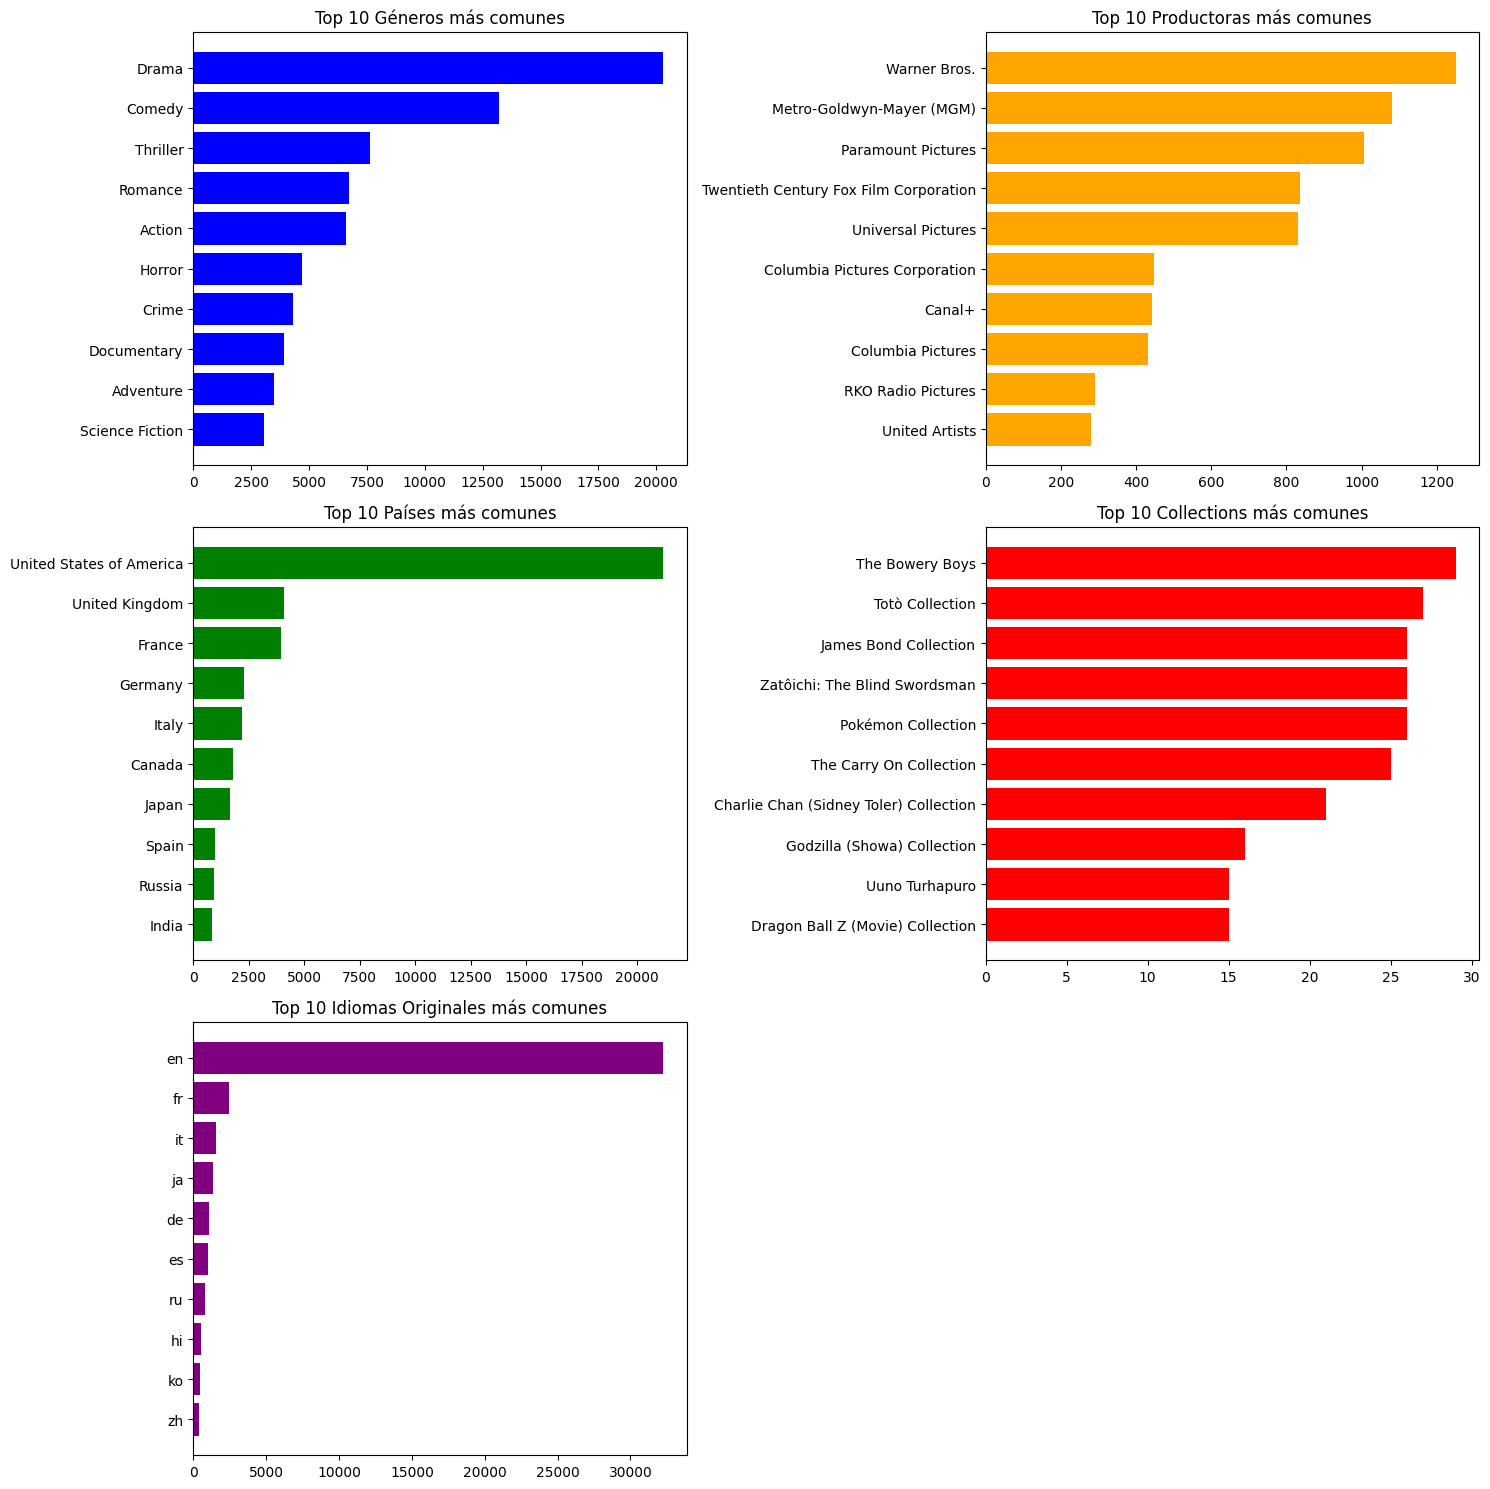

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

top_10_generos = top_10_generos.sort_values(ascending=False)
top_10_productoras = top_10_productoras.sort_values(ascending=False)
top_10_paises = top_10_paises.sort_values(ascending=False)
top_10_collections = top_10_collections.sort_values(ascending=False)
top_10_languages = top_10_or_languaje.sort_values(ascending=False)

axs[0, 0].barh(top_10_generos.index, top_10_generos.values, color='blue')
axs[0, 0].set_title('Top 10 Géneros más comunes')
axs[0, 0].invert_yaxis()

axs[0, 1].barh(top_10_productoras.index, top_10_productoras.values, color='orange')
axs[0, 1].set_title('Top 10 Productoras más comunes')
axs[0, 1].invert_yaxis()

axs[1, 0].barh(top_10_paises.index, top_10_paises.values, color='green')
axs[1, 0].set_title('Top 10 Países más comunes')
axs[1, 0].invert_yaxis()

# Solo si aún tienes suficientes datos para mostrar después de la filtración
if not top_10_collections.empty:
    axs[1, 1].barh(top_10_collections.index, top_10_collections.values, color='red')
    axs[1, 1].set_title('Top 10 Collections más comunes')
    axs[1, 1].invert_yaxis()

axs[2, 0].barh(top_10_or_languaje.index, top_10_or_languaje.values, color='purple')
axs[2, 0].set_title('Top 10 Idiomas Originales más comunes')
axs[2, 0].invert_yaxis()

# Eliminamos el último gráfico vacío si no es necesario
fig.delaxes(axs[2,1])

plt.tight_layout()
plt.show()

- Géneros de películas: Los géneros más comunes en las películas de esta base de datos son el Drama, la Comedia y el Thriller, con 20302, 13195 y 7635 películas, respectivamente. Estos son seguidos por Romance, Acción, Horror y Crimen.

- Colecciones de películas: La mayoría de las películas en la base de datos no pertenecen a ninguna colección, con 40955 películas. Entre las que sí pertenecen a colecciones, las más comunes son "The Bowery Boys", "Totò Collection", y las colecciones de "James Bond" y "Pokémon", cada una con 26-29 películas.

- Productoras de películas: Las compañías productoras más comunes en esta base de datos son Warner Bros. (1250 películas), Metro-Goldwyn-Mayer (MGM) (1080 películas) y Paramount Pictures (1007 películas). Estas son seguidas por Twentieth Century Fox Film Corporation, Universal Pictures, Columbia Pictures Corporation, entre otras.

- Países de producción de películas: Las producciones de películas son principalmente de los Estados Unidos, seguido por el Reino Unido, Francia, Alemania, e Italia.

- Idioma original de las películas: Las películas son en su mayoría en inglés, seguido por francés, italiano, japonés, y alemán.



In [28]:
# Descomponer la columna 'genero_names'
data_exploded = df.explode('genero_names')

# Calcular la popularidad promedio y la calificación promedio de los votos por género
genero_popularity = data_exploded.groupby('genero_names')['popularity'].mean().sort_values(ascending=False)
genero_vote_average = data_exploded.groupby('genero_names')['vote_average'].mean().sort_values(ascending=False)

In [29]:
print(genero_popularity)
print(genero_vote_average)

genero_names
Adventure          5.995128
Fantasy            5.359532
Science Fiction    5.000270
Action             4.769173
Family             4.736971
Animation          4.721759
Thriller           4.488794
Crime              4.148732
Mystery            3.952672
Horror             3.561911
History            3.468825
War                3.331226
Comedy             3.233345
Romance            3.120794
Drama              3.013975
Western            2.629321
Music              2.554191
TV Movie           2.040625
Documentary        0.950552
Foreign            0.765008
Name: popularity, dtype: float64
genero_names
Animation          6.277497
History            6.158626
War                6.041358
Drama              5.904802
Crime              5.880148
Music              5.878500
Documentary        5.828630
Mystery            5.823686
Romance            5.801631
Fantasy            5.781998
Family             5.755624
Foreign            5.746159
Comedy             5.716362
Adventure        

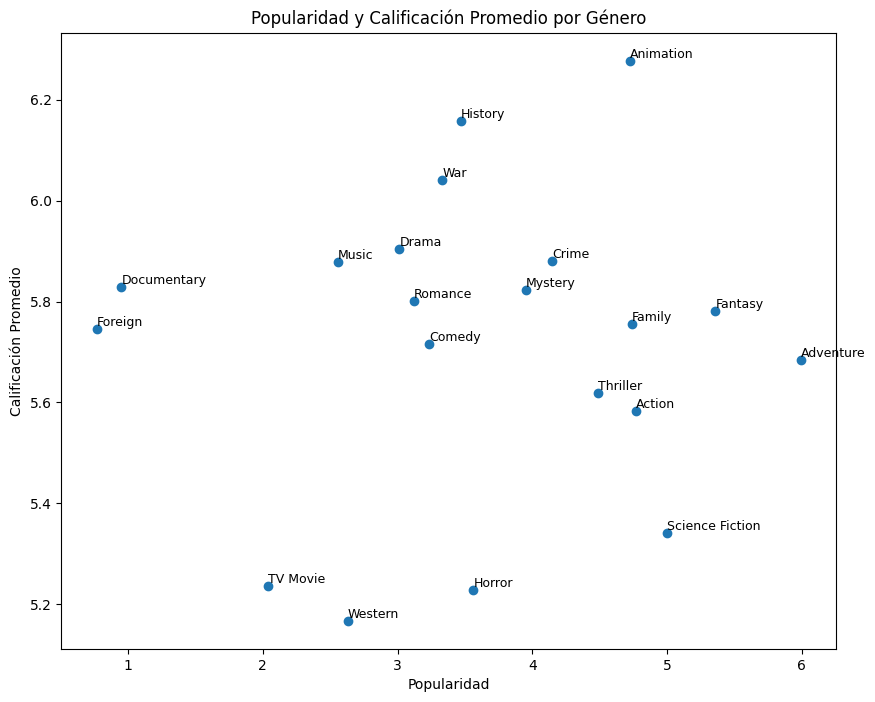

In [30]:
# Crear un DataFrame con los datos agrupados
df_genre = pd.DataFrame({'Popularity': genero_popularity, 'Vote Average': genero_vote_average})

# Crear el gráfico de dispersión
plt.figure(figsize=(10,8))
plt.scatter(df_genre['Popularity'], df_genre['Vote Average'])

# Añadir etiquetas a los puntos
for i in range(df_genre.shape[0]):
    plt.text(df_genre['Popularity'][i], df_genre['Vote Average'][i], df_genre.index[i], 
             horizontalalignment='left', 
             verticalalignment='bottom', 
             fontsize=9)

# Añadir títulos y etiquetas a los ejes
plt.title('Popularidad y Calificación Promedio por Género')
plt.xlabel('Popularidad')
plt.ylabel('Calificación Promedio')

# Mostrar el gráfico
plt.show()


En el grafico arriba se observa que las peliculas mas populares y con mejor calificacion son las del genero "Animation" mientras que las menos populares son las "Foreing" y las "Documentary", que suelen ser para un tipo de audiencia mas espeficica.

In [31]:
# Descomponer la columna 'production_countries_names'
data_exploded = df.explode('production_countries_names')

# Calcular la cantidad de películas, la popularidad promedio y la calificación de voto promedio por país
country_stats = data_exploded.groupby('production_countries_names').agg(
    cantidad_de_peliculas=('title', 'count'),
    popularity=('popularity', 'mean'),
    popularity_std=('popularity', 'std'),
    vote_average=('vote_average', 'mean'),
    vote_average_std=('vote_average', 'std')
)

# Ordenar los resultados por la cantidad de películas
country_stats = country_stats.sort_values(by='cantidad_de_peliculas', ascending=False)

country_stats.head(10)

,cantidad_de_peliculas,popularity,popularity_std,vote_average,vote_average_std
production_countries_names,,,,,
United States of America,21176,4.302564,8.095007,5.601738,1.711590
United Kingdom,4100,4.331602,8.465276,6.031512,1.493075
France,3956,3.090113,3.752972,6.133038,1.426425
Germany,2266,3.414089,4.356845,5.993469,1.614102
Italy,2174,2.277173,3.135774,5.693744,1.961528
Canada,1766,3.832091,7.432656,5.506342,1.653508
Japan,1654,2.529442,3.766853,6.163362,1.746565
Spain,964,2.817778,3.758854,5.654876,1.810058
Russia,911,1.311686,1.957289,5.627552,1.651499


- Producción de Películas: Estados Unidos de América es con creces el país que produce más películas, con un total de 21,176. Esto es más del doble que el siguiente país, Reino Unido, que ha producido 4,100 películas. La lista sigue con Francia, Alemania, Italia, Canadá, Japón, España, Rusia e India.

- Popularidad: A pesar de la gran cantidad de películas producidas por Estados Unidos, el Reino Unido tiene la popularidad media más alta, con un promedio de 4.331602, aunque la diferencia no es significativa respecto a la popularidad de las películas de Estados Unidos. Es importante destacar que la desviación estándar de la popularidad en el Reino Unido es mayor que en los Estados Unidos, lo que significa que hay más variabilidad en la popularidad de las películas británicas.

- Como ya habiamos visto en el Mapa de calor, no parece existir una relacion entre la popularidad de la pelicula y el promedio del puntaje.

- Calificación Promedio: A pesar de las diferencias en la cantidad de películas producidas y la popularidad, Japón lidera en términos de la calificación promedio más alta (6.163362), seguido de cerca por Francia y el Reino Unido. Las películas de Japón también tienen una desviación estándar relativamente alta para la calificación, lo que indica una mayor variabilidad en las calificaciones de las películas japonesas.

- Variabilidad: En términos de variabilidad (medida por la desviación estándar), las películas producidas en el Reino Unido tienen la mayor variabilidad tanto en popularidad como en calificación promedio. Esto podría indicar una gama más amplia de géneros y estilos en las películas del Reino Unido, o podría reflejar una mayor inconsistencia en la calidad de las películas.

- India y Rusia: India y Rusia, a pesar de tener una menor cantidad de películas producidas, tienen calificaciones promedio competitivas (5.945838 y 5.627552 respectivamente). Sin embargo, su popularidad media es significativamente menor que la de los otros países, lo que podría reflejar una menor distribución o visibilidad de sus películas a nivel internacional.

In [32]:
# Director
directors = df.explode('director')
director_stats = directors.groupby('director').agg(
    cantidad_de_peliculas=('title', 'count'),
    popularity=('popularity', 'mean'),
    popularity_std=('popularity', 'std'),
    vote_average=('vote_average', 'mean'),
    vote_average_std=('vote_average', 'std')
)

# Actor principal
actor_stats = df.groupby('principal_actor').agg(
    cantidad_de_peliculas=('title', 'count'),
    popularity=('popularity', 'mean'),
    popularity_std=('popularity', 'std'),
    vote_average=('vote_average', 'mean'),
    vote_average_std=('vote_average', 'std')
)

In [33]:
director_stats.sort_values(by='cantidad_de_peliculas', ascending=False).head(10)

,cantidad_de_peliculas,popularity,popularity_std,vote_average,vote_average_std
director,,,,,
['John Ford'],63,3.029424,3.667543,6.385714,0.838943
['Michael Curtiz'],61,2.015480,2.703665,5.152459,2.503238
['Werner Herzog'],52,2.350297,2.767446,6.788462,0.830699
['Alfred Hitchcock'],52,6.595391,6.015454,6.694231,0.904762
['Georges Méliès'],51,0.641857,0.903868,5.890196,0.925906
['Woody Allen'],47,7.731888,3.251316,6.725532,0.570838
['Sidney Lumet'],45,3.972681,4.216245,6.062222,2.008198
['Charlie Chaplin'],43,2.877422,2.929710,6.581395,0.882975
['Henry Hathaway'],41,2.116341,3.001285,5.590244,1.630001


Vamos a ver el comportamiento de las peliculas segun el director en funcion de la popularidad y la calificacion promedio

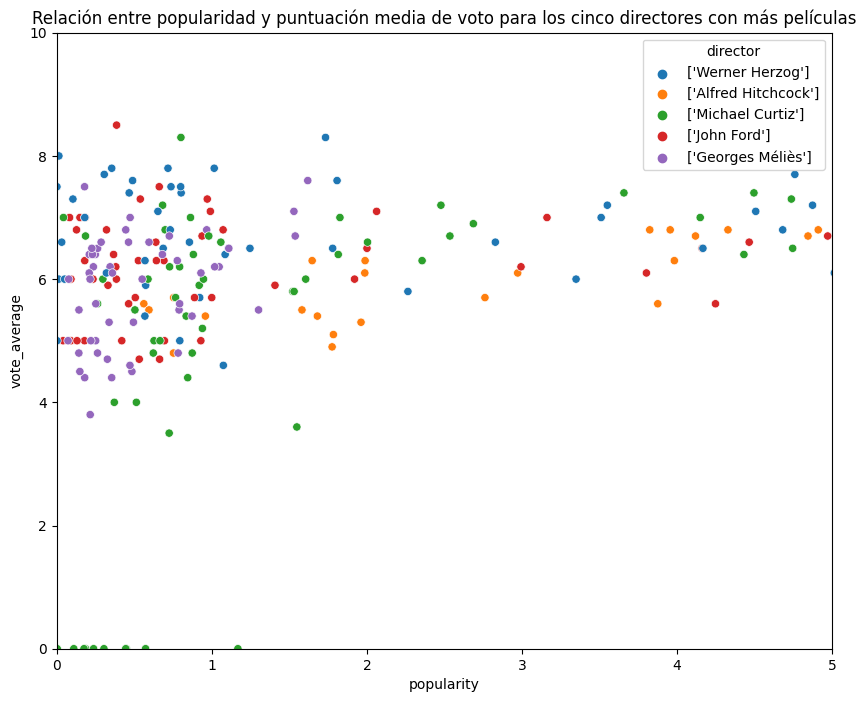

In [34]:
# Obten los nombres de los cinco directores con más películas
top_directors = df['director'].value_counts().index[:5]

# Crea un nuevo DataFrame que contenga solo las películas de estos directores
top_director_movies = df[df['director'].isin(top_directors)]

# Crea un gráfico de dispersión con seaborn
plt.figure(figsize=(10,8))
sns.scatterplot(data=top_director_movies, x='popularity', y='vote_average', hue='director')
plt.title('Relación entre popularidad y puntuación media de voto para los cinco directores con más películas')

# Define los límites de los ejes
plt.xlim(0, 5)  # Aquí establecemos el rango de popularidad entre 0 y 50
plt.ylim(0, 10)  # Aquí establecemos el rango de vote_average entre 0 y 10

plt.show()

En el grafico anterior podemos ver como peliculas del director "Georges Melies" parecen tener un comportamiento similar en cuanto a las dos variables en juego, ademas, casi todas las peliculas se mantienen en un rango de voto promedio similar, pareciera que el director involucrado impacta en la critica del publico de forma relativamente similar en sus diferentes trabajos.

In [35]:
actor_stats.sort_values(by='cantidad_de_peliculas', ascending=False).head(10)

,cantidad_de_peliculas,popularity,popularity_std,vote_average,vote_average_std
principal_actor,,,,,
John Wayne,56,3.653919,3.302625,5.737500,1.136912
Jackie Chan,42,6.591259,4.079442,6.254762,0.728246
Steven Seagal,28,5.872078,2.378871,4.742857,0.716694
Jean-Claude Van Damme,26,7.242446,3.664965,5.046154,0.829569
Clint Eastwood,26,8.053455,2.791996,6.511538,0.677836
Robert De Niro,25,6.096558,4.238075,6.404000,0.932059
Elvis Presley,24,1.825635,1.630766,5.891667,0.678820
Nicolas Cage,24,9.339324,3.831777,5.862500,0.909282
Burt Lancaster,23,3.702135,3.387953,6.191304,0.773371


Según los datos presentados, es evidente que tanto el director como el actor principal de una película podrían desempeñar un papel significativo en su puntuación y popularidad, siendo posiblemente factores valiosos para un modelo de recomendación.

Para los directores, figuras notables como Alfred Hitchcock y Woody Allen demuestran una alta consistencia en las puntuaciones promedio de sus películas, como se evidencia en la baja desviación estándar. Estos directores, que tienen una gran cantidad de películas en su haber, parecen tener una mayor probabilidad de recibir críticas positivas, lo que puede indicar que su estilo y habilidades se han perfeccionado con el tiempo.

Un patrón similar se observa entre los actores principales, con Clint Eastwood, Robert De Niro y Denzel Washington mostrando puntuaciones promedio altas y desviaciones estándar más bajas. Estos actores parecen tener una reputación de aparecer en películas bien recibidas, lo que puede aumentar la probabilidad de que las futuras películas en las que aparezcan también sean populares y bien calificadas.

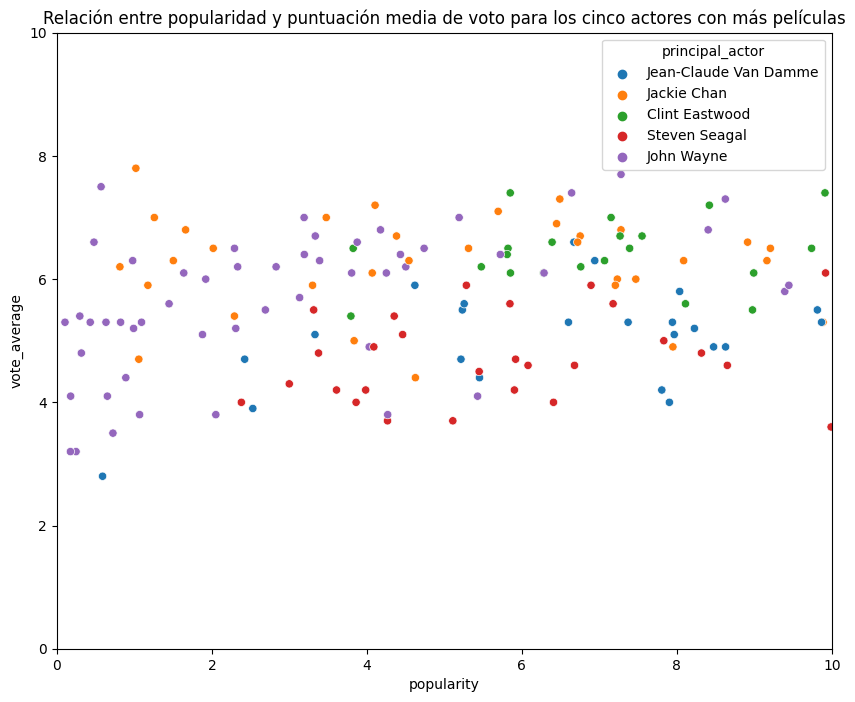

In [36]:
# Obten los nombres de los cinco actores con más películas
top_actors = df['principal_actor'].value_counts().index[:5]

# Crea un nuevo DataFrame que contenga solo las películas de estos actores
top_actors_movies = df[df['principal_actor'].isin(top_actors)]

# Crea un gráfico de dispersión con seaborn
plt.figure(figsize=(10,8))
sns.scatterplot(data=top_actors_movies, x='popularity', y='vote_average', hue='principal_actor')
plt.title('Relación entre popularidad y puntuación media de voto para los cinco actores con más películas')

# Define los límites de los ejes
plt.xlim(0, 10)  # Aquí establecemos el rango de popularidad entre 0 y 5
plt.ylim(0, 10)  # Aquí establecemos el rango de vote_average entre 0 y 10

plt.show()

En el caso de los actores principales se ve el grafico mucho mas disperso y no se puede identificar un patron o relacion entre el actor principal y la popularidad/promedio de voto.

### Analisis de outliers

Analisis de outliers de la feature popularity

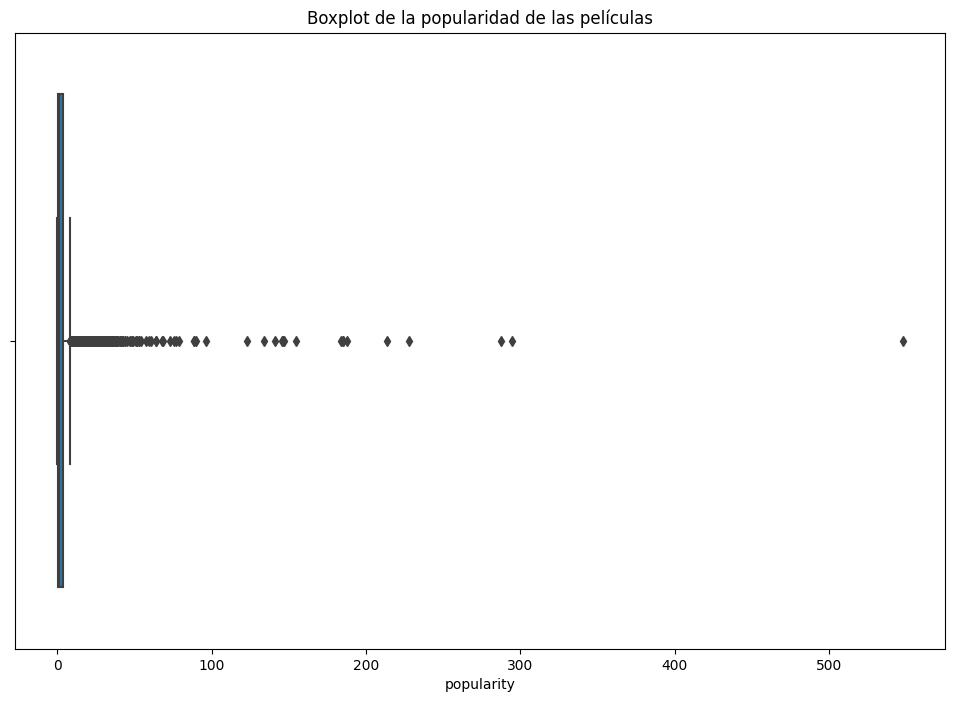

In [37]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=df['popularity'])
plt.title('Boxplot de la popularidad de las películas')
plt.show()

In [38]:
Q1 = df['popularity'].quantile(0.25)
Q3 = df['popularity'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites para los outliers
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

# Filtramos los valores que son outliers
outliers = df[(df['popularity'] < lower_limit) | (df['popularity'] > upper_limit)]

# Imprimimos los outliers
outliers.sort_values(by='popularity',ascending= False).head()


,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,...,genero_names,id_collection,name_collection,production_companies_ids,production_companies_names,production_countries_names,production_countries_iso,spoken_languages_names,director,principal_actor
30731,74000000.0,211672,en,"Minions Stuart, Kevin and Bob are recruited by...",547.488298,2015-06-17,1.156731e+09,91.0,"Before Gru, they had a history of bad bosses",Minions,...,"[Family, Animation, Adventure, Comedy]",86066.0,Despicable Me Collection,"[33, 6704]","[Universal Pictures, Illumination Entertainment]",[United States of America],['US'],['English'],"['Kyle Balda', 'Pierre Coffin']",NaN
33383,149000000.0,297762,en,An Amazon princess comes to the world of Man t...,294.337037,2017-05-30,8.205804e+08,141.0,Power. Grace. Wisdom. Wonder.,Wonder Woman,...,"[Action, Adventure, Fantasy]",468552.0,Wonder Woman Collection,"[444, 507, 6194, 9993, 9995, 81620, 83838]","[Dune Entertainment, Atlas Entertainment, Warn...",[United States of America],['US'],"['Deutsch', 'English']",['Patty Jenkins'],NaN
42224,160000000.0,321612,en,A live-action adaptation of Disney's version o...,287.253654,2017-03-16,1.262886e+09,129.0,Be our guest.,Beauty and the Beast,...,"[Family, Fantasy, Romance]",NaN,NaN,"[2, 10227]","[Walt Disney Pictures, Mandeville Films]","[United Kingdom, United States of America]","['GB', 'US']",['English'],['Bill Condon'],NaN
43640,34000000.0,339403,en,After being coerced into working for a crime b...,228.032744,2017-06-28,2.245113e+08,113.0,All you need is one killer track.,Baby Driver,...,"[Action, Crime]",NaN,NaN,"[443, 559, 2531, 10163, 31922]","[Big Talk Productions, TriStar Pictures, Media...","[United Kingdom, United States of America]","['GB', 'US']",['English'],['Edgar Wright'],NaN
24473,165000000.0,177572,en,The special bond that develops between plus-si...,213.849907,2014-10-24,6.521054e+08,102.0,From the creators of Wreck-it Ralph and Frozen,Big Hero 6,...,"[Adventure, Family, Animation, Action, Comedy]",NaN,NaN,"[2, 6125]","[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],['US'],['English'],"['Chris Williams', 'Don Hall']",NaN


Si vemos las peliculas que aparecen como Outliers vemos que son efectivamente peliculas muy populares, aunque son datos atipicos se ve razon para determinar que los mismos sean incorrectos

Primero, tomaremos las descripciones de las películas (o "resúmenes") y las procesaremos para prepararlas para el análisis. Este preprocesamiento puede incluir pasos como la eliminación de palabras irrelevantes (también conocidas como "stopwords"), la conversión de todas las palabras a minúsculas y la tokenización (la conversión de las descripciones de texto largo en listas de palabras individuales).

## Analisis de Columna Overview (Procesamiento de lenguaje natural)

Vamos a iniciar el trabajo limpiando un poco los datos

In [ ]:
# Los elementos sin descripcion se asignan como NaN para que no influyan en los resultado
df['overview'] = df['overview'].replace('No overview found.', np.nan)

Vamos a inicializar un lemmatizador y definir una funcion que hara el trabajo de normalizacion

In [ ]:
# Inicializa el lematizador
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, print_progress=False):
    # Contador de iteraciones
    counter = 0

    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)

    # Cargar palabras vacías
    stop_words = stopwords.words('english')

    # Verifica si el texto es un número (incluyendo NaN)
    if isinstance(text, (int, float)):
        return ''

    # Convierte el texto a minúsculas
    text = text.lower()

    # Tokeniza el texto
    words = word_tokenize(text)

    # Elimina las palabras vacías
    words = [word for word in words if word not in stop_words]

    # Lematiza las palabras e imprime progreso
    new_words = []
    for word in words:
        new_word = lemmatizer.lemmatize(word)
        new_words.append(new_word)

        # Incrementa contador y verifica si imprimir progreso
        counter += 1
        if print_progress and counter % 1000 == 0:
            print(f"Processed {counter} words.")

    # Une las palabras en una cadena de texto
    text = " ".join(new_words)

    return text

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Aplica la función de preprocesamiento a cada descripción de película
df['overview'] = df['overview'].apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Crea una instancia de CountVectorizer
vectorizer = CountVectorizer()

# Ajustar y transformar los datos
X = vectorizer.fit_transform(df['overview'])

# Sumar las columnas de la matriz X para obtener el recuento total de cada palabra
word_counts = np.array(np.sum(X, axis=0)).flatten()

# Combinar los recuentos de palabras con los nombres de las palabras
words_counts_combined = zip(vectorizer.get_feature_names_out(), word_counts)

# Ordenar las palabras por recuento
words_counts_sorted = sorted(words_counts_combined, key=lambda x: x[1], reverse=True)

# Imprimir las 10 palabras más comunes
for word, count in words_counts_sorted[:10]:
    print(f'Word: {word}, Count: {count}')

In [ ]:
# Suma todas las veces que cada palabra aparece en nuestros textos
word_counts = np.asarray(X.sum(axis=0)).ravel()

# Asocia cada palabra con su recuento
word_counts_dict = dict(zip(vectorizer.get_feature_names_out(), word_counts))

# Genera la nube de palabras
wordcloud = WordCloud(width = 1000, height = 500, random_state=21, max_font_size=110).generate_from_frequencies(word_counts_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Las palabras más comunes en los resúmenes de las películas proporcionan una visión interesante de los temas recurrentes en las películas. "Life", "one" y "film" encabezan la lista, indicando que las tramas suelen girar en torno a historias de vida individuales y se presentan a menudo en un contexto cinematográfico o de filmación.

Palabras como "young", "man" y "love" son indicativos de tramas comunes en las películas que implican personajes jóvenes, a menudo hombres, en situaciones de amor o romance. La palabra "find" también es común, lo que sugiere una prevalencia de tramas basadas en la búsqueda o el descubrimiento.

"Year", "new" y "two" también aparecen con frecuencia, lo que podría indicar una tendencia a las tramas que ocurren durante un período de tiempo determinado (un año), que implican novedades o cambios, o que se centran en dos personajes o elementos principales.

En general, estos hallazgos sugieren que las tramas de las películas a menudo giran en torno a temas de amor, descubrimiento y cambio, y con frecuencia involucran a personajes jóvenes o a hombres en roles principales. Sin embargo, cabe destacar que estas son palabras bastante generales y, por lo tanto, es posible que no proporcionen una representación completa de la variedad de tramas y temas que se encuentran en las películas.

La nube de palabras nos muestra que palabras como "war", "father" y "murder" son bastante comunes en las descripciones de las películas en este dataset. Este hecho puede proporcionar cierta intuición sobre la temática de las películas.

In [ ]:
from sklearn.preprocessing import binarize

# Binarizar la matriz tfidf_matrix
tfidf_matrix_bin = binarize(X)

# Sumar los valores a lo largo del eje 0
word_appearances = np.asarray(tfidf_matrix_bin.sum(axis=0)).ravel()

# Asociar cada palabra con su recuento
word_appearances_dict = dict(zip(vectorizer.get_feature_names_out(), word_appearances))

# Ordenar el diccionario por los recuentos de apariciones de palabras de forma descendente
word_appearances_dict = dict(sorted(word_appearances_dict.items(), key=lambda item: item[1], reverse=True))

# Obten la cantidad total de películas
total_movies = X.shape[0]

# Calcular las proporciones y almacenarlas en un nuevo diccionario
word_appearances_proportions = {word: count / total_movies for word, count in word_appearances_dict.items()}

# Mostrar las 10 palabras más comunes y su proporción del total de películas
for word, proportion in list(word_appearances_proportions.items())[:20]:
    print(f"Word: {word}, Appears in: {proportion:.2%} of the movies")



Hay palabras que aparecen en una gran cantidad de peliculas como "life, one" que quizas no nos sirva para identificar la tematica de la pelicula, pero palabras mas especificas como "family, friend, war, love, young" que nos pueden ser utiles para identificar la tematica.

## Reducción de dimensionalidad y Modelado de Tópicos con LDA (Latent Dirichlet Allocation)

Utilizaremos el Algoritmo de Latent Dirichlet Allocation (LDA) para el modelado de tópicos. LDA asume que cada documento en un corpus está compuesto por una mezcla de tópicos y que cada palabra en el documento se puede atribuir a uno de los tópicos del documento. LDA utiliza un enfoque generativo, lo que significa que intenta volver a crear los documentos originales a partir de los tópicos que ha identificado.

Para utilizar LDA, primero preprocesaremos nuestros documentos (en este caso, descripciones de películas) realizando tareas como la eliminación de palabras vacías y la tokenización. Luego, crearemos una "bolsa de palabras" para cada documento, que es simplemente una lista de las palabras que aparecen en el documento junto con la frecuencia de cada palabra.

Luego, entrenaremos el modelo LDA en nuestras bolsas de palabras. El modelo aprenderá qué palabras tienden a aparecer juntas en los documentos y utilizará esta información para identificar los tópicos. Una vez entrenado, el modelo LDA podrá decirnos la proporción de cada tópico en cada documento, así como las palabras más representativas de cada tópico.

Finalmente, utilizaremos una métrica llamada "coherencia" para evaluar la calidad de nuestro modelo. La coherencia mide qué tan semánticamente similares son las palabras más representativas de cada tópico. Podemos utilizar la coherencia para comparar diferentes modelos o configuraciones de modelos, y para determinar el número óptimo de tópicos.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Descarga el tokenizador de NLTK si aún no lo has hecho
nltk.download('punkt')

# Asegurándome de que las descripciones sean strings
df['overview'] = df['overview'].apply(str)

# Creando una lista de todas las descripciones de las películas
movie_descriptions = df['overview'].tolist()

# Tokenizar las descripciones de las películas
movie_descriptions_tokenized = [word_tokenize(desc) for desc in movie_descriptions]

# Crear el diccionario
dictionary = corpora.Dictionary(movie_descriptions_tokenized)

# Crear el corpus
corpus = [dictionary.doc2bow(desc) for desc in movie_descriptions_tokenized]

for i in range(1,20):
    # Crear el modelo LDA
    lda = models.LdaModel(corpus, num_topics=i, id2word=dictionary, passes=2)

    # Calcular la métrica de coherencia
    coherence_model_lda = CoherenceModel(model=lda, texts=movie_descriptions_tokenized, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    print(f'Coherence Score:{i} es {coherence_lda}')


Basandonos en el parametro de coherencia vamos a seleccionar un numero de topicos de 14

In [ ]:
lda = models.LdaModel(corpus, num_topics=14, id2word=dictionary, passes=2)

In [ ]:
# Asignar cada película a su tema más probable
topics = [max(lda[corpus[i]], key=lambda x: x[1])[0] for i in range(len(movie_descriptions))]

# Contar cuántas películas pertenecen a cada tema
topic_counts = pd.Series(topics).value_counts()

print(topic_counts)

Estos números representan la cantidad de películas que el modelo LDA ha asignado a cada tópico. A partir de estos números, podemos obtener algunas ideas interesantes:

El tópico 13 es el más común, con 18961 películas asignadas. Esto puede sugerir que este tópico representa una temática muy general o popular en las películas de tu conjunto de datos.

Los tópicos 2, 9 y 6 también son relativamente comunes, cada uno con varios miles de películas asignadas.

En el otro extremo del espectro, los tópicos 1, 3 y 4 parecen ser menos comunes, con solo unas pocas docenas o cientos de películas asignadas a cada uno. Estos tópicos pueden representar temas más nicho o específicos que no se encuentran en una gran cantidad de películas.

In [ ]:
# Imprimir los 10 principales términos de cada tema
for idx, topic in lda.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

## KeyWords de Overview

Vamos a obtener las palabras clave de cada resumen, de esta forma podremos comparar si entre los distintos resumenes existen coincidencias

In [34]:
movies = df

In [ ]:
def assign_topic_to_movies(lda_model, corpus, df):
    topic_assignments = []
    
    for i in range(len(corpus)):
        topics = lda_model.get_document_topics(corpus[i])
        topic_assignments.append(max(topics, key=lambda item: item[1])[0])
    
    df['topic'] = topic_assignments

# Llama a la función para asignar los tópicos a las películas
assign_topic_to_movies(lda, corpus, df)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

movies['overview'] = movies['overview'].apply(lambda x: '' if isinstance(x, float) else x)

# Esto es solo necesario la primera vez que uses NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Inicializar el stemmer y las stopwords
stemmer = PorterStemmer()



In [ ]:
#Calcular TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movies['processed_overview'])


In [ ]:
# Obtener las palabras clave para cada película
keywords = []
for i in range(tfidf_matrix.shape[0]):
    tfidf_scores = tfidf_matrix[i]
    words = vectorizer.inverse_transform(tfidf_scores)
    keywords.append(words)

movies['keywords'] = keywords

In [35]:
# Definir una función para limpiar y extraer las palabras clave
def extract_keywords(keywords_str):
    # Reemplaza los caracteres innecesarios
    keywords_str = keywords_str.replace("array([", "").replace("])", "")
    # Divide la cadena en palabras clave usando una coma como separador
    keywords_list = keywords_str.split(',')
    # Elimina los espacios adicionales y devuelve la lista
    return [kw.strip("' ") for kw in keywords_list]

# Aplicar la función a la columna de palabras clave
movies['keywords'] = movies['keywords'].apply(extract_keywords)

# Verificar el resultado
print(movies['keywords'].head())


0    [['differ, asid, put, learn, eventu, duo, owne...
1    [['creatur, terrifi, monkey, evil, rhinocero, ...
2    [['time, hot, cook, seafood, interest, le, awa...
3    [['way, better, determin, talk, robin, glo, be...
4    [['kid, grandchild, arriv, chang, like, home, ...
Name: keywords, dtype: object


In [36]:
movies['keywords'] = movies['keywords'].apply(lambda x: [item.strip() for sublist in x for item in sublist.replace('[', '').replace(']', '').split(',')])

# Verificar el resultado
print(movies['keywords'].head())

0    ['differ, asid, put, learn, eventu, duo, owner...
1    ['creatur, terrifi, monkey, evil, rhinocero, g...
2    ['time, hot, cook, seafood, interest, le, away...
3    ['way, better, determin, talk, robin, glo, ber...
4    ['kid, grandchild, arriv, chang, like, home, s...
Name: keywords, dtype: object


In [43]:
# Función para limpiar las palabras clave
def clean_keyword(keyword):
    return keyword.replace("'", "")

# Aplicar la función de limpieza a la columna
movies['keywords_cleaned'] = movies['keywords'].apply(lambda keywords: [clean_keyword(keyword) for keyword in keywords])

# Elimina el último elemento de cada lista de palabras clave
movies['keywords_cleaned'] = movies['keywords_cleaned'].apply(lambda keywords: keywords[:-1])

Vamos a imprimir por genero las distintas palabras mas frecuentes

In [48]:
from collections import Counter

# Obtener todos los géneros únicos
all_genres = set([genre for genres in movies['genero_names'] for genre in genres])

# Iterar sobre cada género y contar las palabras clave más comunes
for genre in all_genres:
    # Filtrar las películas de este género
    genre_movies = movies[movies['genero_names'].apply(lambda genres: genre in genres)]
    
    # Concatenar todas las palabras clave en una lista
    genre_keywords = [keyword for keywords in genre_movies['keywords_cleaned'] for keyword in keywords]
    
    # Contar las ocurrencias de cada palabra clave
    keyword_counts = Counter(genre_keywords)
    
    # Imprimir las 10 palabras clave más comunes para este género
    print(f"Las 10 palabras clave más comunes para el género {genre} son:")
    for keyword, count in keyword_counts.most_common(10):
        print(f"Keyword: {keyword}, Count: {count}")
    print("\n")


Las 10 palabras clave más comunes para el género a son:
Keyword: life, Count: 6240
Keyword: young, Count: 4259
Keyword: one, Count: 4187
Keyword: love, Count: 3976
Keyword: find, Count: 3925
Keyword: stori, Count: 3694
Keyword: film, Count: 3561
Keyword: new, Count: 3347
Keyword: man, Count: 3254
Keyword: woman, Count: 3153


Las 10 palabras clave más comunes para el género C son:
Keyword: life, Count: 2765
Keyword: get, Count: 2425
Keyword: find, Count: 2292
Keyword: one, Count: 2277
Keyword: new, Count: 1967
Keyword: two, Count: 1852
Keyword: love, Count: 1847
Keyword: friend, Count: 1812
Keyword: young, Count: 1778
Keyword: take, Count: 1755


Las 10 palabras clave más comunes para el género o son:
Keyword: life, Count: 5572
Keyword: one, Count: 4522
Keyword: find, Count: 4260
Keyword: young, Count: 3835
Keyword: new, Count: 3640
Keyword: love, Count: 3623
Keyword: get, Count: 3522
Keyword: film, Count: 3488
Keyword: take, Count: 3362
Keyword: two, Count: 3261


Las 10 palabras clav

In [55]:
movies

,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,...,production_countries_names,production_countries_iso,spoken_languages_names,director,principal_actor,topic,processed_overview,keywords,keywords2,keywords_cleaned
0,30000000.0,862,en,led woody andy toy live happily room andy birt...,21.946943,1995-10-30,373554033.0,81.0,0,Toy Story,...,['United States of America'],['US'],['English'],['John Lasseter'],NaN,13,led woodi andi toy live happili room andi birt...,"['differ, asid, put, learn, eventu, duo, owner...",[diffe],"[differ, asid, put, learn, eventu, duo, owner,..."
1,65000000.0,8844,en,sibling judy peter discover enchanted board ga...,17.015539,1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,...,['United States of America'],['US'],"['English', 'Français']",['Joe Johnston'],Robin Williams,5,sibl judi peter discov enchant board game open...,"['creatur, terrifi, monkey, evil, rhinocero, g...",[creatu],"[creatur, terrifi, monkey, evil, rhinocero, gi..."
2,0.0,15602,en,family wedding reignites ancient feud nextdoor...,11.712900,1995-12-22,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,...,['United States of America'],['US'],['English'],['Howard Deutch'],NaN,9,famili wed reignit ancient feud nextdoor neigh...,"['time, hot, cook, seafood, interest, le, away...",[tim],"[time, hot, cook, seafood, interest, le, away,..."
3,16000000.0,31357,en,cheated mistreated stepped woman holding breat...,3.859495,1995-12-22,81452156.0,127.0,Friends are the people who let you be yourself...,Waiting to Exhale,...,['United States of America'],['US'],['English'],['Forest Whitaker'],Whitney Houston,13,cheat mistreat step woman hold breath wait elu...,"['way, better, determin, talk, robin, glo, ber...",[wa],"[way, better, determin, talk, robin, glo, bern..."
4,0.0,11862,en,george bank recovered daughter wedding receive...,8.387519,1995-02-10,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,...,['United States of America'],['US'],['English'],['Charles Shyer'],Steve Martin,13,georg bank recov daughter wed receiv news preg...,"['kid, grandchild, arriv, chang, like, home, s...",[ki],"[kid, grandchild, arriv, chang, like, home, se..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45447,0.0,30840,en,yet another version classic epic enough variat...,5.683753,1991-05-13,0.0,104.0,0,Robin Hood,...,"['Canada', 'Germany', 'United Kingdom', 'Unite...","['CA', 'DE', 'GB', 'US']",['English'],['John Irvin'],Patrick Bergin,2,yet anoth version classic epic enough variat m...,"['variat, darker, tone, photographi, marian, m...",[varia],"[variat, darker, tone, photographi, marian, ma..."
45448,0.0,111109,tl,artist struggle finish work storyline cult pla...,0.178241,2011-11-17,0.0,360.0,0,Century of Birthing,...,['Philippines'],['PH'],[''],['Lav Diaz'],NaN,2,artist struggl finish work storylin cult play ...,"['storylin, artist, cult, play, struggl, work,...",[storyli],"[storylin, artist, cult, play, struggl, work, ..."
45449,0.0,67758,en,one hit go wrong professional assassin end sui...,0.903007,2003-08-01,0.0,90.0,A deadly game of wits.,Betrayal,...,['United States of America'],['US'],['English'],['Mark L. Lester'],NaN,9,one hit go wrong profession assassin end suitc...,"['belong, suitcas, million, wrong, full, mob, ...",[belon],"[belong, suitcas, million, wrong, full, mob, p..."
45450,0.0,227506,en,small town live two brother one minister one h...,0.003503,1917-10-21,0.0,87.0,0,Satan Triumphant,...,['Russia'],['RU'],[],['Yakov Protazanov'],NaN,13,small town live two brother one minist one hun...,"['ehem, cuckold, earthli, stormi, viewpoint, a...",[ehe],"[ehem, cuckold, earthli, stormi, viewpoint, ad..."


In [60]:
from collections import defaultdict, Counter

# Crea un diccionario para almacenar las cuentas de palabras clave para cada género
keyword_counts_by_genre = defaultdict(Counter)

# Itera a través de las filas del marco de datos
for index, row in movies.iterrows():
    genero_names = ast.literal_eval(row['genero_names'])  # Convierte la cadena en una lista
    keywords_cleaned = row['keywords_cleaned']

    # Itera a través de los géneros en la lista de géneros
    for genero in genero_names:
        # Suma las cuentas de palabras clave para este género
        keyword_counts_by_genre[genero].update(keywords_cleaned)

# Imprime las 10 palabras clave más comunes para cada género
for genero, keyword_counts in keyword_counts_by_genre.items():
    print(f"Las 10 palabras clave más comunes para el género {genero} son:")
    for keyword, count in keyword_counts.most_common(10):
        print(f"Keyword: {keyword}, Count: {count}")

Las 10 palabras clave más comunes para el género Animation son:
Keyword: anim, Count: 310
Keyword: find, Count: 309
Keyword: world, Count: 289
Keyword: one, Count: 281
Keyword: life, Count: 273
Keyword: new, Count: 259
Keyword: friend, Count: 251
Keyword: take, Count: 236
Keyword: must, Count: 223
Keyword: young, Count: 209
Las 10 palabras clave más comunes para el género Comedy son:
Keyword: life, Count: 2249
Keyword: get, Count: 1997
Keyword: find, Count: 1820
Keyword: one, Count: 1774
Keyword: love, Count: 1646
Keyword: new, Count: 1634
Keyword: friend, Count: 1540
Keyword: two, Count: 1486
Keyword: take, Count: 1374
Keyword: young, Count: 1356
Las 10 palabras clave más comunes para el género Family son:
Keyword: find, Count: 509
Keyword: life, Count: 481
Keyword: famili, Count: 440
Keyword: friend, Count: 430
Keyword: new, Count: 424
Keyword: get, Count: 401
Keyword: young, Count: 361
Keyword: one, Count: 356
Keyword: take, Count: 344
Keyword: world, Count: 332
Las 10 palabras clav

La aparición frecuente de palabras como "find", "life", "young" y "friend" en múltiples géneros demuestra que existen temas universales que podrían ser esenciales en la conexión con las preferencias de los espectadores. Por lo tanto, estos datos pueden ser utilizados para mejorar la precisión de las recomendaciones, alineando las películas sugeridas con los intereses y gustos individuales de los usuarios.

Además, al explorar y clasificar estas palabras clave dentro de cada género, el sistema de recomendación puede ofrecer opciones más personalizadas y dirigidas, mejorando así la experiencia del usuario. Por ejemplo, si un usuario muestra una fuerte inclinación hacia películas que contienen el tema "amistad", el sistema podría recomendar más películas en diferentes géneros que también enfatizan este tema.

## Conclusion final y variables decisoras

Basándonos en nuestro análisis previo, se puede inferir que las variables que podrían ser más útiles para el modelo de recomendación son:

- Género de la película: Dado que cada género tiene su propio conjunto único de características y atrae a diferentes audiencias, es probable que el género sea un predictor valioso en un modelo de recomendación.

- Collection: Esta variable va a ser util cuando este disponible para identificar otras peliculas de la misma coleccion.

- Descripción de la película (Overview): A través de técnicas de procesamiento de lenguaje natural, la descripción de una película puede ser utilizada para encontrar similitudes en el contenido entre diferentes películas. Si una persona disfruta de una película, es probable que disfrute de películas con descripciones similares. Por lo tanto, este podría ser un predictor fuerte en un modelo de recomendación basado en contenido. Se utilizara mediante la coincidencia de Topicos.

En resumen, nuestro análisis nos ha proporcionado una visión detallada de los datos de las películas de TMDB. Hemos identificado algunas características interesantes y patrones en los datos, y hemos desarrollado un método para medir la similitud entre las descripciones de las películas. Este análisis puede ser un punto de partida útil para tareas futuras, como la construcción de un sistema de recomendación de películas o la realización de un análisis más profundo de las características de las películas.

In [63]:
df.to_csv('movies.csv')

In [6]:
pd.set_option('display.max_columns', None)

In [8]:
def recommend_movies(movie_title, movies, n_recommendations=5):
    # Extraer las características de la película seleccionada
    selected_movie = movies[movies['title'] == movie_title].iloc[0]

    # Calcular similitud basada en colección
    similarity = (movies['name_collection'] == selected_movie['name_collection']) * 10 if pd.notnull(selected_movie['name_collection']) else 0

    # Calcular similitud basada en tópico
    similarity += (movies['topic'] == selected_movie['topic']) * 0.5

    # Calcular similitud basada en género
    similarity += movies['genero_names'].apply(lambda x: sum(g in x for g in selected_movie['genero_names'])) * 0.2

    # Calcular similitud basada en palabras clave
    similarity += movies['keywords_cleaned'].apply(lambda x: sum(k in x for k in selected_movie['keywords_cleaned'])) * 0.5

    # Obtener las películas más similares
    top_n = movies.loc[similarity.nlargest(n_recommendations + 1).index[1:]]

    return top_n

recommend_movies('Jumanji', df, 5)


,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,vote_average,vote_count,release_year,return,genero_ids,genero_names,id_collection,name_collection,production_companies_ids,production_companies_names,production_countries_names,production_countries_iso,spoken_languages_names,director,principal_actor,topic,processed_overview,keywords,keywords_cleaned
1939,0.0,10122,en,1986 disney adventure tell story 12yearold dav...,5.526865,1986-07-30,18564613.0,90.0,Come along on the greatest adventure of the su...,Flight of the Navigator,6.9,227.0,1986,0.0,"[10751, 878, 12]","['Family', 'Science Fiction', 'Adventure']",NaN,NaN,"[2, 1340, 11670]","['Walt Disney Pictures', 'New Star Entertainme...",['United States of America'],['US'],['English'],['Randal Kleiser'],Joey Cramer,6,1986 disney adventur tell stori 12yearold davi...,"[""'perplex"", 'overjoy', 'fla', 'lauderdal', 'u...","['perplex', 'overjoy', 'fla', 'lauderdal', 'uf..."
1949,0.0,34774,en,search castaway 1962 walt disney production fe...,2.679615,1962-12-01,0.0,98.0,"A Thousand Thrills, And Hayley Mills!",In Search of the Castaways,6.2,20.0,1962,0.0,"[28, 12, 18, 10751]","['Action', 'Adventure', 'Drama', 'Family']",NaN,NaN,[3166],['Walt Disney Productions'],['United States of America'],['US'],['English'],['Robert Stevenson'],NaN,2,search castaway 1962 walt disney product featu...,"[""'1868"", 'hawley', 'lowel', 'stevenson', 'che...","['1868', 'hawley', 'lowel', 'stevenson', 'chev..."
8131,0.0,19893,en,many kid might say best friend puppy pony 12ye...,2.439867,1963-08-14,0.0,87.0,The wonderful story of a boy and his amazing u...,Flipper,5.1,17.0,1963,0.0,"[12, 18, 10751]","['Adventure', 'Drama', 'Family']",NaN,NaN,[5328],['Ivan Tors Productions'],['United States of America'],['US'],['English'],['James B. Clark'],Chuck Connors,2,mani kid might say best friend puppi poni 12ye...,"[""'mitzi"", 'fin', 'dolphinpow', '196468', 'hal...","['mitzi', 'fin', 'dolphinpow', '196468', 'halp..."
42848,0.0,334939,de,grandfather car accident isabel 11 take search...,0.906563,2015-06-24,0.0,0.0,0,Sword of D'Artagnan,7.1,8.0,2015,0.0,"[10751, 12]","['Family', 'Adventure']",NaN,NaN,"[15163, 35206, 50837]","['Algemene Vereniging Radio Omroep (AVRO)', 'L...",['Netherlands'],['NL'],['Nederlands'],['Dennis Bots'],NaN,5,grandfath car accid isabel 11 take search swor...,"[""'artagnan"", 'illustri', 'rik', 'persever', '...","['artagnan', 'illustri', 'rik', 'persever', 'b..."
12613,0.0,14784,en,hospital outskirt 1920s los angeles injured st...,15.855108,2008-01-03,3669465.0,117.0,A little blessing in disguise.,The Fall,7.7,430.0,2008,0.0,"[12, 14, 18]","['Adventure', 'Fantasy', 'Drama']",NaN,NaN,"[911, 3586, 11150, 11151, 11152, 11153]","['Roadside Attractions', 'Absolute Entertainme...","['United States of America', 'India']","['US', 'IN']","['English', 'Română', 'Latin']",['Tarsem Singh'],NaN,5,hospit outskirt 1920 lo angel injur stuntman b...,"[""'fractur"", 'stuntman', 'blur', 'fantast', 'o...","['fractur', 'stuntman', 'blur', 'fantast', 'ou..."


In [ ]:
df[df['title'] == 'Jurassic Park']

In [ ]:
# Obtener las palabras clave para cada película
keywords = []
for i in range(tfidf_matrix.shape[0]):
    tfidf_scores = tfidf_matrix[i]
    words = vectorizer.inverse_transform(tfidf_scores)
    keywords.append(words)

movies['keywords'] = keywords